<a href="https://colab.research.google.com/github/AnandShegde/pml_baselines/blob/main/PyStan/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  import pystan
except:
  %pip install -qq pystan
  import pystan
import tensorflow as tf
import numpy as np
import seaborn as sns
import numpy as np
import jax
import jax.numpy as jnp
!pip install tensorflow_probability
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import arviz as az

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pickle
with open("/content/LogisticRegression/coin_toss_data",'rb') as f:
    data = pickle.load(f)
data

{'data': {'x': array([[  6.5395775,  -4.5521317,   1.       ],
         [-25.367474 ,   5.484623 ,   1.       ],
         [-29.124176 ,  14.979027 ,   1.       ],
         ...,
         [  8.335999 ,  17.390522 ,   1.       ],
         [ 12.186649 , -28.44703  ,   1.       ],
         [ 20.430092 ,  22.396717 ,   1.       ]], dtype=float32),
  'y': array([[[1],
          [0],
          [0],
          [0],
          [0],
          [0],
          [0],
          [1],
          [1],
          [1],
          [0],
          [1],
          [1],
          [0],
          [1],
          [1],
          [1],
          [0],
          [0],
          [1],
          [0],
          [0],
          [0],
          [0],
          [1],
          [1],
          [0],
          [1],
          [1],
          [0],
          [0],
          [1],
          [1],
          [1],
          [1],
          [1],
          [0],
          [0],
          [0],
          [0],
          [1],
          [1],
          [0],
      

In [ ]:
X = data['data']['x']
Y = data['data']['y'][0,:,0]
prior_var=data['prior']['covariance_matrix']
prior_mean=data['prior']['loc']
prior_var.shape

(3, 3)

In [ ]:
# # LinearRegression_NormalDist="""
# # data {
# #   int<lower=0> N;
# #   matrix[N,2] x;
# #   vector[N] y;
# #   vector[2] mean_prior;
# #   matrix[2,2] var_prior;
# #   matrix[10,10] diag;
# # }
# # parameters {
# #   vector[2] theta;
# # }
# # model {
# #   theta ~ multi_normal(mean_prior,var_prior);
# #   y ~ multi_normal(x*theta,diag);
# # }
# """

In [ ]:
LogisticRegression_dist="""
data{
  int<lower=0>N;
  matrix[N,3] x;
  int<lower=0,upper=1> y[N];
  vector[3] prior_mean;
  matrix[3,3] prior_var;
}
parameters{
  vector[3] theta;
}
model{
  theta~multi_normal(prior_mean,prior_var);
  y ~ bernoulli_logit(x*theta);
}
"""

In [ ]:
model_LogisticRegression = pystan.StanModel(model_code=LogisticRegression_dist)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cbb1a006700ddd26ab63e3a8de8af429 NOW.


In [ ]:
data = {
    'N':1000,
    'x':X,
    'y':Y,
    'prior_mean':prior_mean,
    'prior_var':prior_var,
}

In [ ]:
model_LogisticRegression_hmc = model_LogisticRegression.sampling(data=data, chains=8, warmup=500, iter=1500)

In [ ]:
model_LogisticRegression_hmc

Inference for Stan model: anon_model_cbb1a006700ddd26ab63e3a8de8af429.
8 chains, each with iter=1500; warmup=500; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   1.84  7.7e-3   0.29   1.33   1.64   1.82   2.03   2.46   1463    1.0
theta[2]  -0.93  3.8e-3   0.15  -1.24  -1.03  -0.92  -0.83  -0.67   1476    1.0
theta[3]   1.82    0.01   0.43   1.04   1.52   1.81    2.1    2.7   1701    1.0
lp__     -44.51    0.03   1.24 -47.78  -45.1 -44.21  -43.6 -43.07   2219    1.0

Samples were drawn using NUTS at Mon Jun  6 17:08:36 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc5c1a4610>,
      dtype=object)

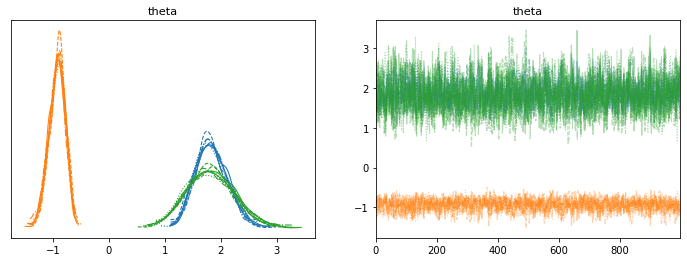

In [ ]:
az.plot_trace(model_LogisticRegression_hmc, figsize = (12, 4))

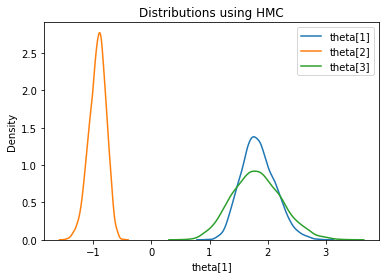

In [ ]:
model_LogisticRegression_df = model_LogisticRegression_hmc.to_dataframe()

theta1_hmc = model_LogisticRegression_df['theta[1]']
sns.kdeplot(theta1_hmc,label="theta[1]")

theta2_hmc = model_LogisticRegression_df['theta[2]']
sns.kdeplot(theta2_hmc,label="theta[2]")

theta3_hmc = model_LogisticRegression_df['theta[3]']
sns.kdeplot(theta3_hmc,label="theta[3]")

plt.title("Distributions using HMC")
plt.legend()
plt.show()

#**Using Variational Inference**

In [ ]:
model_LogisticRegression_vi=model_LogisticRegression.vb(data=data)

In [ ]:
model_LogisticRegression_vi['mean_pars']

[2.234420953184239, -1.0372680658451228, 2.040561937839126]

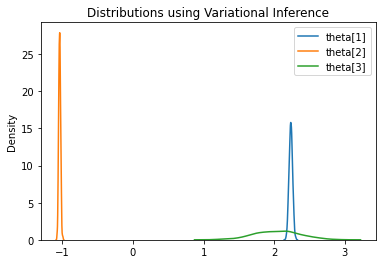

In [ ]:
theta1_vi=np.array(model_LogisticRegression_vi.get('sampler_params')[0])
sns.kdeplot(theta1_vi,label="theta[1]")

theta2_vi=np.array(model_LogisticRegression_vi.get('sampler_params')[1])
sns.kdeplot(theta2_vi,label="theta[2]")

theta3_vi=np.array(model_LogisticRegression_vi.get('sampler_params')[2])
sns.kdeplot(theta3_vi,label="theta[3]")

plt.title("Distributions using Variational Inference")
plt.legend()
plt.show()

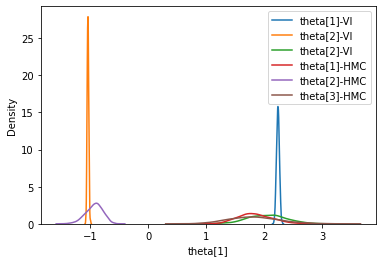

In [ ]:
sns.kdeplot(theta1_vi,label="theta[1]-VI")
sns.kdeplot(theta2_vi,label="theta[2]-VI")
sns.kdeplot(theta3_vi,label="theta[2]-VI")

sns.kdeplot(theta1_hmc,label="theta[1]-HMC")
sns.kdeplot(theta2_hmc,label="theta[2]-HMC")
sns.kdeplot(theta3_hmc,label="theta[3]-HMC")

plt.legend()
plt.show()